In [1]:
import cv2
import numpy as np
import csv
import tensorflow

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D 
from keras.layers import Lambda, Cropping2D, Dropout, ELU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

/anaconda3/envs/tensorgpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#load lines in csv file to read the images 
def load_csv(file):
    lines = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    return lines[1:]

In [3]:
# generally load images in the file 
def load_images(lines_path, image_path):
    path = image_path 
    lines = lines_path
    images = []
    angles = []
    
    for line in lines:
        for i in range(3):
            source_path = line[i]
            filename = source_path.split('/')[-1]
            current_path = path+filename
            image = cv2.imread(current_path)
            images.append(image)
            angle = float(line[3])
            if i == 0:
                angles.append(angle)
            elif i == 1:
                angles.append(angle + 0.20)
            else:
                angles.append(angle - 0.20)
    X_train = np.array(images)
    y_train = np.array(angles) 
    return X_train, y_train

## Load Images and Split 

In [4]:
file = './data-udacity/driving_log.csv'
image_path = './data-udacity/IMG/'

#load image names in the csv file
lines_path = load_csv(file)

#split not the data just their names
# We don't need to test images because it is a regression problem not classification.
train_samples, validation_samples = train_test_split(lines_path, shuffle=True, test_size=0.2)

In [5]:
X_train, y_train = load_images(train_samples, image_path)
X_valid, y_valid = load_images(validation_samples, image_path)

#Check Train and Valid data samples
assert len(X_train) == len(y_train), "X_train {} and y_train {} are not equal".format(len(X_train), len(y_train))
assert len(X_valid) == len(y_valid), "X_valid {} and y_valid {} are not equal".format(len(X_valid), len(y_valid))
print('Total Train samples: {}\nTotal Valid samples: {}'.format(len(X_train), len(X_valid)))

Total Train samples: 19284
Total Valid samples: 4824


In [6]:
#Shuffle train and validation sets - also keras have a shuffle attribute in training
X_train_s, y_train_s = shuffle(X_train, y_train)
X_valid_s, y_valid_s= shuffle(X_valid, y_valid)

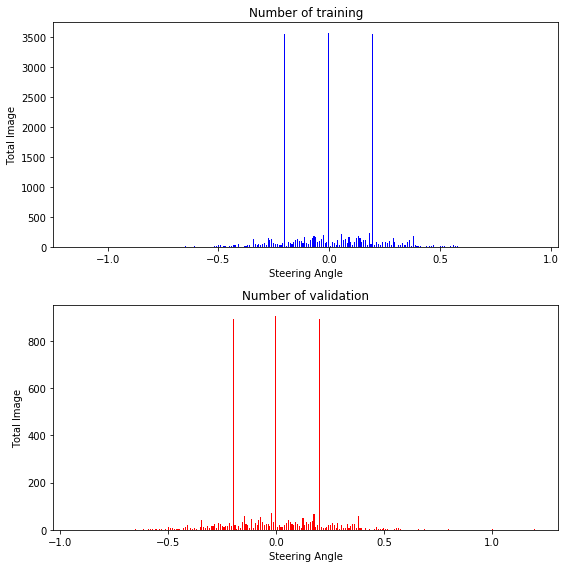

In [33]:
# Check and show the train, validation data steering feature
def show_steering(y_train, y_valid):
    '''take train and validation data label-steering and visualize a histogram.
    input: y_train : train set label,
           y_valid : validation set label,
    output: Histogram of labels'''
        
    max_degree = 25
    degree_per_steering =10
    n_classes = max_degree * degree_per_steering
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    plt.subplots_adjust(left=0, right=0.95, top=0.9, bottom=0.25)
    ax0, ax1= axes.flatten()

    ax0.hist(y_train, bins=n_classes, histtype='bar', color='blue', rwidth=0.6, label='train')
    ax0.set_title('Number of training')
    ax0.set_xlabel('Steering Angle')
    ax0.set_ylabel('Total Image')

    ax1.hist(y_valid, bins=n_classes, histtype='bar', color='red', rwidth=0.6, label='valid')
    ax1.set_title('Number of validation')
    ax1.set_xlabel('Steering Angle')
    ax1.set_ylabel('Total Image')

    fig.tight_layout()
    plt.show()
#show     
show_steering(y_train, y_valid)

As you see data is not a normal distribution if we load this data to network -0.2, 0, +0.2 degrees overweighted the other steering angles. 

I think we have two option. First one is when I load the data to network I cut overweigted degrees (as mention above) make it all degrees have normal distribution. It seems a good option, however when thinking machine learning intuition it is not a good option, why? Because we lost some of the data and load to network very low data might makes it overfitted. 

Second option is generate a new, augmented data. It is opposite of the first option. Instead of cut the overweigted steering angles, this time we augmented the data that the other steering angles have more that and get nearly normal distribution. So I choose this option. 

# Augmention Phase

How to augment data, I have some options:

-Load left and right images(I did it above) 

-Make some images flip

-Make some images brighten

Also I have more options that like scale, zoom or crop images. However this are change the shape of the image that I don't need on this regression project.Check the document for augmentation on Keras https://keras.io/preprocessing/image/.

In [25]:
def image_brighten(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    default_bias = 0.25
    brightness = default_bias + np.random.uniform() 
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * brightness
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def bias(n):
    return 1. / (n + 1.)

In [26]:
def bias(batch_number):
    '''take batch number and return a bias term'''
    return 1. / (batch_number + 1.)

In [27]:
def generator(lines_path, image_path, batch_size=32):
    path = image_path 
    lines = lines_path
    sum_lines = len(lines)
    batch_number=1
    while 1: 
        shuffle(lines)
        for offset in range(0, sum_lines, batch_size):
            batch_samples = lines[offset:offset+batch_size]      
            images = []
            angles = []
            for batch_sample in batch_samples:
                img_choice = np.random.randint(3)
                angle = float(batch_sample[3])
                if angle + bias(batch_number) < np.random.uniform():
                    if img_choice == 0:
                        name =path +batch_sample[1].split('/')[-1]
                        if abs(angle) > 1:
                            angle += 0.25
                        else:
                            angle+=0.18
                    elif img_choice == 1:
                        name = path+batch_sample[0].split('/')[-1]     
                    else:
                        name = path+batch_sample[2].split('/')[-1]
                        if abs(angle) > 1:
                            angle -= 0.25
                        else:
                            angle-=0.18
                    image = cv2.imread(name)
                    if np.random.randint(10) == 0:
                        images.append(image)
                        angles.append(angle)               
                    if angle!=0.18 and angle!=-0.18 and angle!=0:
                        if np.random.randint(3) == 0:
                            image_new = np.fliplr(image)
                            angle_new = -angle
                            images.append(image_new)
                            angles.append(angle_new)
                        if np.random.randint(3) == 1 or 2:
                            image_new = image_brighten(image)
                            images.append(image_new)
                            angles.append(angle)
                            if np.random.randint(3) == 2:
                                image_new = np.fliplr(image)
                                angle_new = -angle
                                images.append(image_new)
                                angles.append(angle_new)    
                batch_number +=1              
            X_train = np.array(images)
            y_train = np.array(angles)    
            yield shuffle(X_train, y_train)

In [28]:
# Load the images via generator
train_generator = generator(train_samples, image_path)
validation_generator = generator(validation_samples, image_path)


In [35]:
#For visualize lets make some samples that 1024 images for each
x_train_gen, y_train_gen = [], [] 
x_valid_gen, y_valid_gen = [], [] 

x_train_gen, y_train_gen = (next(generator(train_samples, image_path, batch_size=1024)))
x_valid_gen, y_valid_gen = (next(generator(validation_samples, image_path, batch_size=1024)))

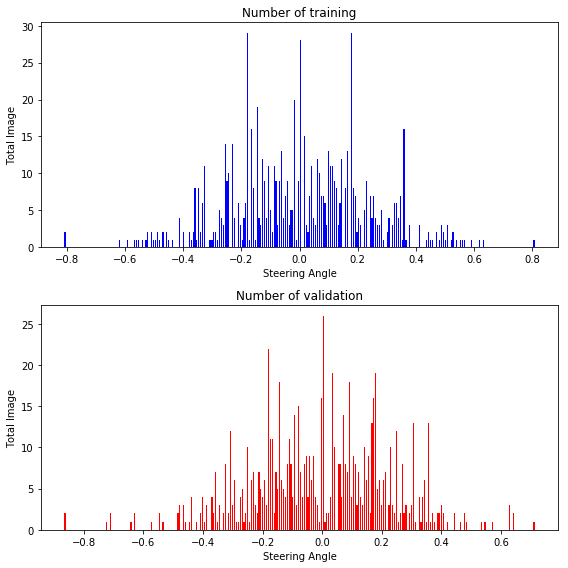

In [36]:
show_steering(y_train_gen, y_valid_gen)

As augmented data, instead of select not all left, center or right image, randomly select of them. So more than 19k data decrease but not using overweighted data give us better result. And in augmented phase not use 0 degree bias images, so we gets better distribution. I can't say it is perfect but it can be more useable. 

In [38]:
counter = 0
def normal_load(lines_path, image_path):
    global counter
    path = image_path 
    lines = lines_path
    total = len(lines_path)

    shuffle(lines)
    
    images = []
    angles = []
    
    while total >= len(angles):
        for line in lines:
            img_choice = np.random.randint(3)
            angle = float(line[3])
            if angle + bias(counter) < np.random.uniform():
                if img_choice == 0:
                    name =path + line[1].split('/')[-1]

                    if abs(angle) > 1:
                        angle += 0.25
                    else:
                        angle+=0.18
                elif img_choice == 1:
                    name = path + line[0].split('/')[-1]     
                else:
                    name = path + line[2].split('/')[-1]
                    if abs(angle) > 1:
                        angle -= 0.25
                    else:
                        angle-=0.18

                image = cv2.imread(name)
                if np.random.randint(10) == 0:
                    images.append(image)
                    angles.append(angle)


                if angle!=0.18 and angle!=-0.18 and angle!=0:
                    for i in range(3):
                        if np.random.randint(3) == 0:
                            image_new = np.fliplr(image)
                            angle_new = -angle
                            images.append(image_new)
                            angles.append(angle_new)

                        if np.random.randint(3) == 1 or 2:
                            image_new = image_brighten(image)
                            images.append(image_new)
                            angles.append(angle)
                            if np.random.randint(3) == 2:
                                image_new = np.fliplr(image)
                                angle_new = -angle
                                images.append(image_new)
                                angles.append(angle_new) 
            counter +=1                

    X_train = np.array(images)
    y_train = np.array(angles)

    return shuffle(X_train, y_train)    

In [39]:
import time
t0 = time.time()
X_train_normal, y_train_normal = normal_load(train_samples, image_path)
X_valid_normal, y_valid_normal = normal_load(validation_samples, image_path)
t1=time.time()
print("total seconds for loaded: {} sn".format(round(t1-t0)))

total seconds for loaded: 109 sn


In [40]:
print(len(X_train_normal))

14286


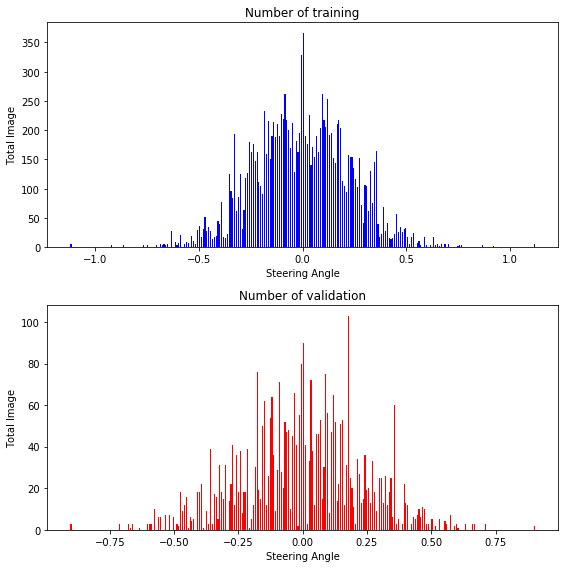

In [41]:
show_steering(y_train_normal, y_valid_normal)

# Model Selection

-First, crop unneeded part of the image(as suggested in udacity lesson)

-Resize image to a small one

-Normalize the data

-Use 5 convolution layers with batch normalization and activation if ELU

-1 Flatten layer and 3 dense layer with activation ELU and using dropout to not overfit the network

-Optimizer Adam with learning rate 1e-5 instead of default 1e-3

In [8]:
def resize(img):
    import tensorflow
    return tensorflow.image.resize_images(img, (60, 120))

In [9]:
model = Sequential()

# Crop 70 pixels from the top of the image and 25 from the bottom
model.add(Cropping2D(cropping=((75, 25), (0, 0)),
                     input_shape=(160, 320, 3),
                     data_format="channels_last"))

# Resize the data
model.add(Lambda(resize))

# Normalize the data
model.add(Lambda(lambda x: (x/127.5) - 0.5))

model.add(Conv2D(3, (1, 1), padding='same'))
model.add(ELU())

model.add(BatchNormalization())
model.add(Conv2D(16, (5, 5), strides=(2, 2), padding="same"))
model.add(ELU())

model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
model.add(ELU())

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
model.add(ELU())

model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
model.add(ELU())

model.add(Flatten())
model.add(ELU())

model.add(Dense(512))
model.add(Dropout(.2))
model.add(ELU())

model.add(Dense(100))
model.add(Dropout(.5))
model.add(ELU())

model.add(Dense(10))
model.add(Dropout(.5))
model.add(ELU())

model.add(Dense(1))

adam = Adam(lr=1e-5)
model.compile(optimizer= adam, loss="mse", metrics=['accuracy'])

#Showing model and params, it is a heavy network with nearly 2.2 bilion params
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 60, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 60, 120, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 60, 120, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 120, 3)        12        
_________________________________________________________________
elu_1 (ELU)                  (None, 60, 120, 3)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 120, 3)        12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 60, 16)        1216      
__________

In [50]:
file = 'model_generator.h5'
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(file, monitor='val_loss', verbose=1, save_best_only=True)
model.fit_generator(train_generator, steps_per_epoch= len(train_samples),
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples), epochs = 1)
model.save(file)

Epoch 1/1
6428/6428 [==============================] - 567s 88ms/step - loss: 0.0288 - acc: 0.0234 - val_loss: 0.0188 - val_acc: 0.0237


In [47]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_nor.h5', monitor='val_loss', verbose=1, save_best_only=True)
results = model.fit(X_train_normal, y_train_normal,
                    validation_data=(X_valid_normal, y_valid_normal),
                    batch_size=32, epochs=50, verbose=1)
model.save('model_nor.h5')

Train on 14286 samples, validate on 3458 samples
Epoch 1/50
14286/14286 [==============================] - 22s 2ms/step - loss: 0.1515 - acc: 0.0069 - val_loss: 0.0295 - val_acc: 0.0067
Epoch 2/50
14286/14286 [==============================] - 20s 1ms/step - loss: 0.1425 - acc: 0.0062 - val_loss: 0.0287 - val_acc: 0.0067
Epoch 3/50
14286/14286 [==============================] - 20s 1ms/step - loss: 0.1365 - acc: 0.0066 - val_loss: 0.0291 - val_acc: 0.0067
Epoch 4/50
14286/14286 [==============================] - 20s 1ms/step - loss: 0.1289 - acc: 0.0067 - val_loss: 0.0269 - val_acc: 0.0067
Epoch 5/50
14286/14286 [==============================] - 20s 1ms/step - loss: 0.1215 - acc: 0.0070 - val_loss: 0.0263 - val_acc: 0.0067
Epoch 6/50
14286/14286 [==============================] - 20s 1ms/step - loss: 0.1185 - acc: 0.0066 - val_loss: 0.0279 - val_acc: 0.0067
Epoch 7/50
14286/14286 [==============================] - 19s 1ms/step - loss: 0.1110 - acc: 0.0070 - val_loss: 0.0256 - val_acc:

In [11]:
#For fun lets train raw data
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_row.h5', monitor='val_loss', verbose=1, save_best_only=True)
results = model.fit(X_train_s, y_train_s,
                    validation_data=(X_valid_s, y_valid_s),
                    batch_size=32, epochs=30, verbose=1)
model.save('model_row.h5')

Train on 19284 samples, validate on 4824 samples
Epoch 1/30
19284/19284 [==============================] - 27s 1ms/step - loss: 0.6170 - acc: 0.0891 - val_loss: 0.0614 - val_acc: 0.1843
Epoch 2/30
19284/19284 [==============================] - 26s 1ms/step - loss: 0.5452 - acc: 0.0902 - val_loss: 0.0520 - val_acc: 0.1847
Epoch 3/30
19284/19284 [==============================] - 26s 1ms/step - loss: 0.5045 - acc: 0.0927 - val_loss: 0.0413 - val_acc: 0.1847
Epoch 4/30
19284/19284 [==============================] - 26s 1ms/step - loss: 0.4886 - acc: 0.0960 - val_loss: 0.0400 - val_acc: 0.1847
Epoch 5/30
19284/19284 [==============================] - 25s 1ms/step - loss: 0.4659 - acc: 0.0964 - val_loss: 0.0365 - val_acc: 0.1847
Epoch 6/30
19284/19284 [==============================] - 26s 1ms/step - loss: 0.4445 - acc: 0.0967 - val_loss: 0.0393 - val_acc: 0.1845
Epoch 7/30
19284/19284 [==============================] - 26s 1ms/step - loss: 0.4310 - acc: 0.1010 - val_loss: 0.0353 - val_acc: